In [1]:
%load_ext autoreload

In [2]:
%autoreload
import pygmsh
import numpy as np
import jax.numpy as jnp
from dctkit.mesh import util, simplex
from dctkit.math.opt import optctrl
from dctkit.physics.elasticity import LinearElasticity
import dctkit.dec.cochain as C
import dctkit as dt
from matplotlib.pyplot import triplot
from functools import partial

In [3]:
dt.config()

In [4]:
lc = 0.2
L = 1.
with pygmsh.geo.Geometry() as geom:
    p = geom.add_polygon([[0., 0.], [L, 0.], [L, L], [0., L]], mesh_size=lc)
    # create a default physical group for the boundary lines
    geom.add_physical(p.lines, label="boundary")
    geom.add_physical(p.lines[0], label="down")
    geom.add_physical(p.lines[2], label="up")
    geom.add_physical(p.lines[1], label="right")
    geom.add_physical(p.lines[3], label="left")
    mesh = geom.generate_mesh()

S = util.build_complex_from_mesh(mesh)
S.get_hodge_star()
S.get_flat_DPD_weights()
S.get_flat_DPP_weights()

ref_node_coords = S.node_coords

In [5]:
down_bnd_nodes_idx = util.get_nodes_for_physical_group(mesh, 1, "down")
up_bnd_nodes_idx = util.get_nodes_for_physical_group(mesh, 1, "up")
down_bnd_edges_idx = util.get_edges_for_physical_group(S, mesh, "down")
up_bnd_edges_idx = util.get_edges_for_physical_group(S, mesh, "up")
left_bnd_nodes_idx = util.get_nodes_for_physical_group(mesh, 1, "left")
right_bnd_nodes_idx = util.get_nodes_for_physical_group(mesh, 1, "right")
left_bnd_edges_idx = util.get_edges_for_physical_group(S, mesh, "left")
right_bnd_edges_idx = util.get_edges_for_physical_group(S, mesh, "right")

print(down_bnd_edges_idx)
print(up_bnd_edges_idx)
print(left_bnd_nodes_idx)
print(right_bnd_nodes_idx)

[0, 12, 15, 18, 3]
[7, 34, 37, 40, 9]
[0, 3, 16, 17, 18, 19]
[1, 2, 8, 9, 10, 11]


In [6]:
mu_ = 1.
lambda_ = 10.
gamma_ = 0.2
tau_ = mu_*gamma_
true_curr_node_coords = S.node_coords.copy()
true_curr_node_coords[:, 0] += gamma_*S.node_coords[:, 1]
up_bnd_pos_components = [0]

up_bnd_nodes_pos_x = true_curr_node_coords[up_bnd_nodes_idx, 0]
up_bnd_nodes_pos_y = ref_node_coords[up_bnd_nodes_idx, 1]
down_bnd_pos = ref_node_coords[down_bnd_nodes_idx, :]

In [7]:
# NOTE: without flatten it does not work properly when concatenating multiple bcs;
# fix this so that flatten is not needed (not intuitive)
boundary_values = {"0": (up_bnd_nodes_idx, up_bnd_nodes_pos_x),
                   ":": (down_bnd_nodes_idx, down_bnd_pos)}
ela = LinearElasticity(S=S, mu_=mu_, lambda_=lambda_)
gamma = 1000000.
num_faces = S.S[2].shape[0]
embedded_dim = S.space_dim
#f = np.zeros((num_faces, (embedded_dim-1)))
f = np.zeros((S.num_nodes, (embedded_dim-1)), dtype=dt.float_dtype)
curr_node_coords = jnp.full(
    S.node_coords.shape, jnp.nan, dtype=dt.float_dtype)
#obj = ela.obj_linear_elasticity_energy
#obj = ela.obj_linear_elasticity_primal
#x0 = S.node_coords.flatten()
# x0 = true_curr_node_coords.flatten()

unknown_node_coords = S.node_coords.copy()
unknown_node_coords[up_bnd_nodes_idx , 0] = np.nan
unknown_node_coords[down_bnd_nodes_idx, :] = np.nan
unknown_node_coords_flattened = unknown_node_coords.flatten()
unknown_node_idx = ~np.isnan(unknown_node_coords_flattened)
x0 = unknown_node_coords_flattened[unknown_node_idx]
obj = partial(ela.obj_linear_elasticity_dual,
                          unknown_node_idx=unknown_node_idx)

# traction bcs
primal_vol_left = S.primal_volumes[1][left_bnd_edges_idx]
primal_vol_right = S.primal_volumes[1][right_bnd_edges_idx]
idx_left_right_edges = left_bnd_edges_idx + right_bnd_edges_idx
bnd_tractions_up = np.zeros(len(up_bnd_edges_idx), dtype=dt.float_dtype)
bnd_tractions_left = -tau_*np.ones(len(left_bnd_edges_idx), dtype=dt.float_dtype)
bnd_tractions_left *= primal_vol_left
bnd_tractions_left[-1] *= -1
bnd_tractions_right = tau_*np.ones(len(right_bnd_edges_idx), dtype=dt.float_dtype)
bnd_tractions_right *= primal_vol_right
bnd_tractions_right[-1] *= -1
bnd_tractions_left_right = np.zeros(len(idx_left_right_edges), dtype = dt.float_dtype)
idx_tract_y = up_bnd_edges_idx + idx_left_right_edges
bnd_tractions_y = np.concatenate((bnd_tractions_up, bnd_tractions_left, bnd_tractions_right))
#bnd_tractions_y = np.concatenate((bnd_tractions_left, bnd_tractions_right))

boundary_tractions = {'1': (idx_tract_y, bnd_tractions_y),
                     '0': (idx_left_right_edges, bnd_tractions_left_right)}
#obj_args = {'f': f, 'gamma': gamma, 'boundary_values': boundary_values}
obj_args = {'f': f,
            'boundary_values': boundary_values,
            'boundary_tractions': boundary_tractions,
            'curr_node_coords': curr_node_coords}
#obj_args = {'f': f, 'gamma': gamma, 'boundary_values': boundary_values, 'boundary_tractions': boundary_tractions}

In [9]:
prb = optctrl.OptimizationProblem(dim=len(x0), state_dim=len(x0),objfun=obj)

prb.set_obj_args(obj_args)
sol = prb.solve(x0=x0, ftol_abs=1e-12, ftol_rel=1e-12, maxeval = 20000)
print(prb.last_opt_result)
#curr_node_coords = sol.reshape(S.node_coords.shape)
#print(len(sol))
curr_node_coords = ela.set_displacement_bc(curr_node_coords, boundary_values)
curr_node_coords_flattened = curr_node_coords.flatten()
curr_node_coords_flattened = curr_node_coords_flattened.at[jnp.isnan(
    curr_node_coords_flattened)].set(sol)
curr_node_coords = curr_node_coords_flattened.reshape(S.node_coords.shape)

3


In [9]:
#print(obj(sol, f, gamma, boundary_values, boundary_tractions))
#print(obj(true_curr_node_coords.flatten(), f, gamma, boundary_values, boundary_tractions))
true_node_coch = C.CochainP0(S, true_curr_node_coords)
f_coch = C.CochainP2(S, f)
#res = ela.force_balance_residual_primal(true_node_coch, f_coch, boundary_tractions)
forces = ela.force_balance_residual_primal(true_node_coch, f_coch, boundary_tractions)
#print(res.coeffs)
#bad_coeffs =np.where(np.abs(res.coeffs[:,1]) > 1e-8)
#print(bad_coeffs)

In [13]:
forces.coeffs[down_bnd_edges_idx,:]

Array([[-4.00000000e-02,  1.02140518e-15],
       [-4.00000000e-02, -4.11010492e-16],
       [-4.00000000e-02, -5.32907052e-16],
       [-4.00000000e-02,  7.67914291e-17],
       [ 4.00000000e-02,  4.44089210e-16]], dtype=float64)

In [32]:
bad_cells = S.S[2][bad_coeffs, :]
print(bad_cells)
print(S.node_coords[bad_cells])

[[[19  0 40]
  [11  2 39]]]
[[[[0.         0.2        0.        ]
   [0.         0.         0.        ]
   [0.14641016 0.14641016 0.        ]]

  [[1.         0.8        0.        ]
   [1.         1.         0.        ]
   [0.85358984 0.85358984 0.        ]]]]


In [10]:
strain = ela.get_infinitesimal_strain(curr_node_coords)
stress = ela.get_stress(strain)

print("strain=", strain)
print("stress=", stress)

strain= [[[ 6.47539071e-08  9.99997466e-02]
  [ 9.99997466e-02 -8.29451751e-08]]

 [[ 2.45285370e-09  9.99997304e-02]
  [ 9.99997304e-02 -1.45783940e-10]]

 [[-2.73191030e-08  1.00000051e-01]
  [ 1.00000051e-01  4.01143678e-08]]

 [[-9.03550669e-08  9.99997415e-02]
  [ 9.99997415e-02  1.05487298e-07]]

 [[ 6.22123628e-08  1.00000049e-01]
  [ 1.00000049e-01 -6.68493079e-08]]

 [[-7.41382219e-08  9.99997804e-02]
  [ 9.99997804e-02  1.03278365e-07]]

 [[ 5.16455421e-08  9.99997665e-02]
  [ 9.99997665e-02 -7.96102937e-08]]

 [[-4.05271998e-08  9.99999452e-02]
  [ 9.99999452e-02  6.42104050e-08]]

 [[ 7.41784589e-08  9.99999563e-02]
  [ 9.99999563e-02 -9.72818023e-08]]

 [[ 2.58964232e-07  9.99999432e-02]
  [ 9.99999432e-02 -3.21902073e-07]]

 [[ 4.44089210e-16  1.00000128e-01]
  [ 1.00000128e-01 -1.82617910e-09]]

 [[-2.51786444e-07  9.99999234e-02]
  [ 9.99999234e-02  3.14836291e-07]]

 [[ 3.43078499e-09  1.00000061e-01]
  [ 1.00000061e-01 -4.54828741e-09]]

 [[ 2.22044605e-16  9.99996989

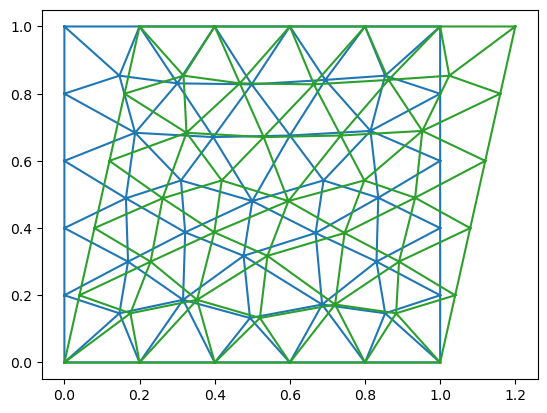

In [11]:
triplot(ref_node_coords[:,0], ref_node_coords[:,1], triangles=S.S[2])
triplot(curr_node_coords[:,0], curr_node_coords[:,1], triangles=S.S[2])

In [11]:
print(ela.obj_linear_elasticity_energy(curr_node_coords, f, gamma, boundary_values))
print(ela.obj_linear_elasticity_energy(true_curr_node_coords, f, gamma, boundary_values))
node_coords_coch = C.CochainP0(complex=S, coeffs=curr_node_coords)
f_coch = C.CochainP2(complex=S, coeffs=f)
elastic_energy = ela.elasticity_energy(node_coords_coch, f_coch)
print(elastic_energy)

0.03999987556931914
0.04000000000000001
0.03999987556931903


In [12]:
#print(true_curr_node_coords)
#print(curr_node_coords)
print(np.allclose(true_curr_node_coords, curr_node_coords, atol=1e-11))

True
